In [1]:
# Import Libraries
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Activation
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from PIL import UnidentifiedImageError
import numpy as np
from sklearn.metrics import classification_report

### Brief description of the problem and data
Briefly describe the challenge problem and NLP. Describe the size, dimension, structure, etc., of the data. 

The challenge involves developing an algorithm to detect metastatic cancer in small image patches extracted from larger digital pathology scans. The dataset, derived from the PatchCamelyon (PCam) benchmark dataset, consists of 220,025 image patches, each labeled with a binary classification indicating the presence or absence of metastatic cancer. The dataset's structure comprises two columns: 'id' for image identifiers and 'label' denoting the presence (1) or absence (0) of tumor tissue. With a 50/50 balance between positive and negative examples in theory, the actual distribution leans slightly towards negatives, with approximately 60% negatives and 40% positives. The images are in TIF format with a size of 96x96 pixels and contain three channels with 8 bits per channel. Although the dataset has been scrubbed of duplicates, this has not been validated through testing. The data's quality is deemed sufficient for diagnostic purposes, having been sourced from routine clinical care, although scanning issues may affect some images' clarity.

Size: rows = 220,025, columns = 2

Dimensions = 2

Structure:
- Dataframe
- Column Names: id (non-null, object), label (non-null, int64)
- No Missing Values
- Label: (0: 130,908, 1: 89,117) - Binary: Absence (0), Presence (1)

67,636 in train

57,458 in test


In [2]:
# Read the CSV file containing the training labels
data = pd.read_csv('train_labels.csv')

# Get the list of file paths for the training data
train_path = os.listdir("./train")

# Get the list of file paths for the test data
test_path = os.listdir("./test")

In [3]:
# Size of Data
print("Size of the data (rows, columns):", data.shape)

# Dimensions of Data
print("\nDimensions of the data:", data.ndim)

# Structure of Data
print("\nStructure of the data:")
print(data.info())

# First Few Rows of Data
print("\nFirst few rows of the data:")
print(data.head())

Size of the data (rows, columns): (220025, 2)

Dimensions of the data: 2

Structure of the data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB
None

First few rows of the data:
                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0


In [4]:
# Missing Values
print("\nMissing Values:")
print(data.isnull().sum())

# Unique Values
print("\nUnique Values in 'label' column:")
print(data['label'].unique())

# Label Statistics
label_counts = data['label'].value_counts()
print("\nLabel statistics:")
print(label_counts)


Missing Values:
id       0
label    0
dtype: int64

Unique Values in 'label' column:
[0 1]

Label statistics:
label
0    130908
1     89117
Name: count, dtype: int64


In [5]:
# Print the number of pictures in the training dataset
print(f'{len(train_path)} pictures in train.')

# Print the number of pictures in the test dataset
print(f'{len(test_path)} pictures in test.')

220025 pictures in train.
57458 pictures in test.


### Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

Show a few visualizations like histograms. Describe any data cleaning procedures. Based on your EDA, what is your plan of analysis? 

The exploratory data analysis (EDA) begins with a visualization showing the distribution of cancerous versus non-cancerous images in the dataset, indicating an imbalance with more non-cancerous samples. Subsequent visualizations include sample images and histograms illustrating color distribution differences between cancerous and non-cancerous cells. The histograms reveal distinct patterns in pixel value frequencies across different color channels, providing insights into potential features for classification.

To address the imbalance, a data cleaning procedure is implemented to balance the dataset through random oversampling of cancerous images. This ensures that both classes are adequately represented in the training data. Additionally, a class is introduced to create image generators for training, validation, and testing, incorporating data augmentation and normalization techniques. Verification steps confirm the successful creation of generators and the existence of image files in the specified directory, ensuring data integrity for subsequent analysis.

The plan of analysis involves leveraging the balanced dataset and image generators to train a machine learning model for classifying cancerous and non-cancerous cells based on image features. The model will be trained using convolutional neural networks (CNNs) to effectively learn discriminative features from the images and make accurate predictions. Subsequent evaluation on the test set will validate the model's performance and potential deployment for practical applications such as medical diagnosis.

#### Visualization of Amount of Cancerous Vs. NonCancerous Images in DataSet

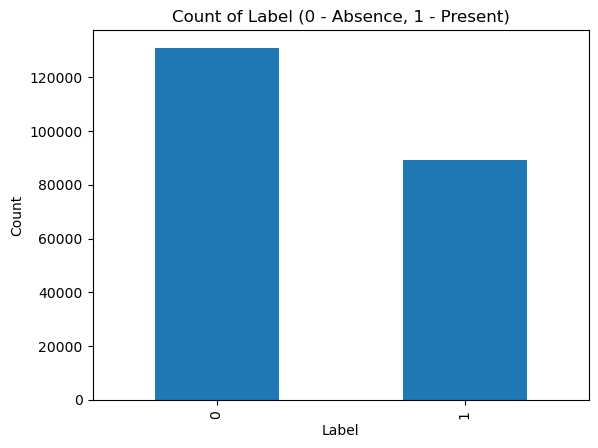

In [6]:
# Ploting the count of each label in the 'label' column of the DataFrame
data.label.value_counts().plot(kind='bar')
plt.title('Count of Label (0 - Absence, 1 - Present)')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

There are more absence of cancerous cells (0) than present in cancerous cells (1). 

With over 120,000 images of non-cancerous cells, but only over 80,000 images of cancerous cells.

Currently, the dataset is unbalanced with cancerous cells being 2/3 the number of non-cancerous.

#### Visualization of Images (Cancerous vs. NonCancerous) and color distribution differences

The Viewer class is designed to facilitate the exploration of a dataset consisting of images and corresponding labels indicating the presence or absence of cancerous cells. Upon initialization, it takes the path to the training data.

The read_image method retrieves an image given its identifier, checking for any potential errors in reading.

The draw_sample_images method displays a selection of images from the dataset, organized into two rows corresponding to the presence or absence of cancer. Each row displays a few sample images along with their respective labels.

The plot_color_histograms method generates histograms for each color channel (Red, Green, Blue) and the combined RGB channels. These histograms depict the distribution of pixel values in images categorized by the presence or absence of cancer.

The data is loaded from a CSV file containing image labels. Finally, an instance of the Viewer class is created with the path to the training data, and the draw_sample_images method is invoked to visualize sample images along with their labels.

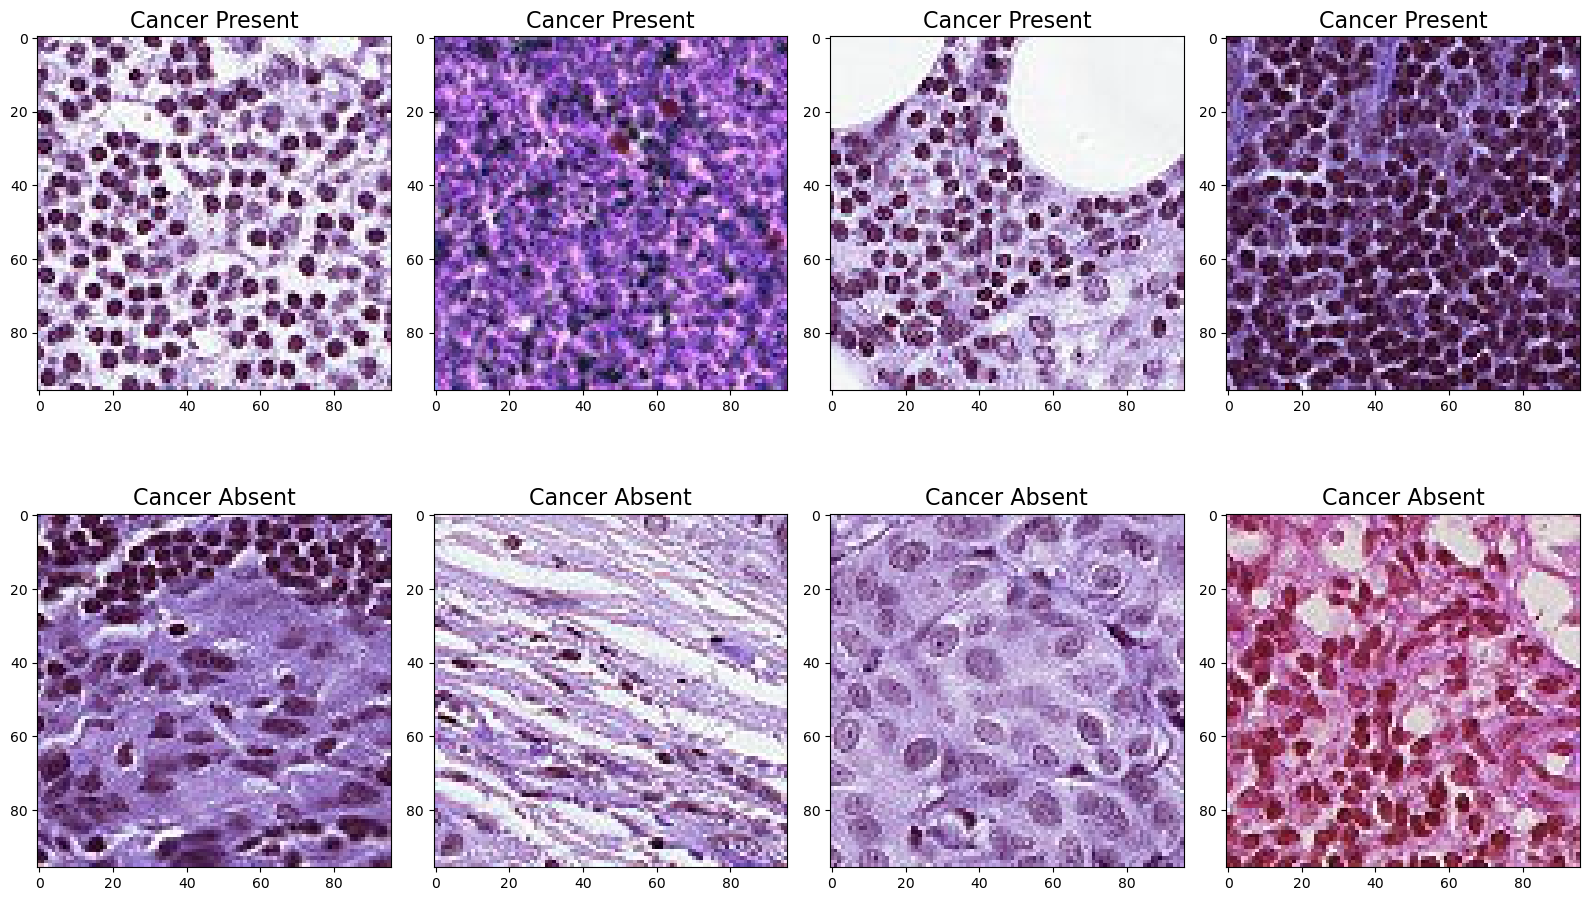

In [16]:
class Viewer:
    def __init__(self, train):
        # Initalize the Viewer object with the path to the training data
        self.train = train
    def read_image(self, id):
        # Read an image given its ID
        file = os.path.join(self.train, str(id) + '.tif')
        try:
            im = cv2.imread(file)
            if im is None:
                # If the image cannot be read, print an error message and return None
                print(f"Unable to read image: {file}. Skipping...")
                return None
            else:
                return im
        except Exception as e:
            # If an error occurs while reading the image, print an error message and return None
            print(f"Error reading image: {file}, {e}. Skipping...")
            return None
    def draw_sample_images(self):
        # Plot sample images with their corresponding labels
        ncols = 4
        f, ax = plt.subplots(nrows=2, ncols=ncols, figsize=(4 * ncols, 5 * 2))
        i = -1
        # Select random samples for the current label
        captions = ['Cancer Present', 'Cancer Absent']
        for label in [0, 1]:
            i += 1
            samples = data[data['label'] == label]['id'].sample(ncols).values
            for j in range(0, ncols):
                file_id = samples[j]
                im = self.read_image(file_id)
                if im is not None:
                    ax[i, j].imshow(im)
                    ax[i, j].set_title(captions[i], fontsize=16)
        plt.tight_layout()
        plt.show()
    def plot_color_histograms(self):
        # Plot color histograms for same images
        ncols = 4
        captions = ['Cancer Present', 'Cancer Absent']
        all_hist = {'Red': [[], []], 'Green': [[], []], 'Blue': [[], []], 'RGB': [[], []]}  
        for label in [1, 0]: 
            samples = data[data['label'] == label]['id'].sample(ncols).values
            for file_id in samples:
                im = self.read_image(file_id)
                if im is not None:
                    for c, channel in enumerate(['Red', 'Green', 'Blue']):
                        hist, _ = np.histogram(im[:, :, c].flatten(), bins=256, density=True)
                        all_hist[channel][label].append(hist)
                    hist, _ = np.histogram(im.flatten(), bins=256, density=True)
                    all_hist['RGB'][label].append(hist)
        plt.figure(figsize=(15, 10))
        for i, channel in enumerate(['Red', 'Green', 'Blue', 'RGB']):
            plt.subplot(2, 2, i+1)
            for label in [1, 0]:
                plt.plot(np.mean(all_hist[channel][label], axis=0), label=f'Cancer {"Present" if label == 1 else "Absent"}')
            plt.title(f'{channel} Histograms')
            plt.xlabel('Pixel Value')
            plt.ylabel('Frequency')
            plt.legend()
            plt.grid(True)
        plt.tight_layout()
        plt.show()
# Read the training labels data        
data = pd.read_csv('train_labels.csv')
# Set the path to the training data directory
train_path = "./train"
# Create a Viewer object and draw sample images
Viewer(train_path).draw_sample_images()

The images above meaning is not too clear on how to tell which slide is cancerous vs. noncancerous to layman like me. So, I want to explore the images more and see the differences by mapping the differences in the color distribution.

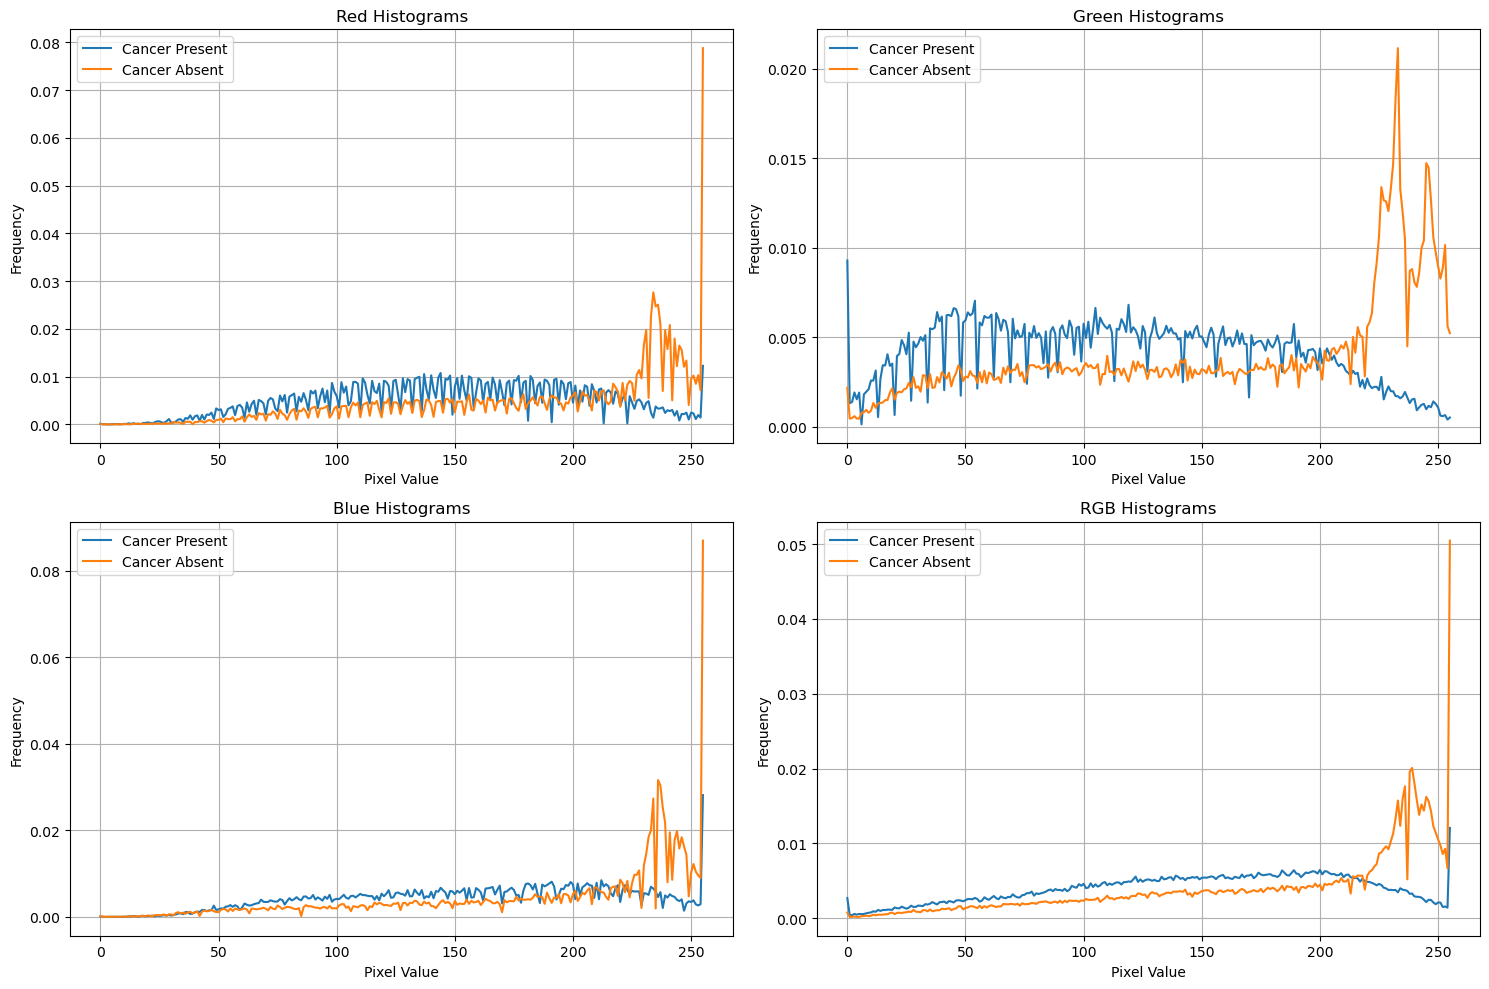

In [8]:
# Create a Viewer object and plot color histograms
Viewer(train_path).plot_color_histograms()

The histograms reveal intriguing patterns in the distribution of pixel values for cancerous and noncancerous cells across different color channels. In the red histogram, the frequency of cancerous cells is notably higher than noncancerous cells until the pixel values exceed 200, at which point noncancerous cells become predominant. This trend is echoed in the blue and RGB histograms as well.

Examining the green histogram, it's apparent that the frequency range is narrower compared to red and blue. The maximum frequency of noncancerous cells in the green channel is around 0.020, whereas in the red and blue channels, it reaches up to 0.080. Interestingly, in the red and blue histograms, the frequency of cancerous cells steadily increases until the pixel value of 200, where it experiences a slight decrease before sharply rising. Conversely, in the green histogram, the frequency of cancerous cells starts high, decreases significantly, then gradually rises until reaching a pixel value of 200, after which it steadily decreases.

### Data Preprocessing and Plan of Analysis

In preparing the data for model training, I implemented several preprocessing steps to ensure optimal performance and robustness of the convolutional neural network (CNN) models. The first step involved splitting the dataset into training and testing sets using the train_test_split function from scikit-learn. After splitting the data, I appended the file extension ".tif" to the image IDs in both the training and testing datasets to match the file naming convention of the image files.

One crucial aspect of data preprocessing is handling class imbalance, which can adversely affect model training and performance. To address this issue, I balanced the number of samples in each class within the training set. This was achieved by oversampling the minority class (cancerous cells) to match the number of samples in the majority class (non-cancerous cells). By ensuring a balanced distribution of samples across classes, the model can learn from a more representative dataset and make more accurate predictions.

In addition to addressing class imbalance, I applied normalization to the image data to standardize the pixel values. Normalization involves scaling the pixel values to a range between 0 and 1, which helps stabilize and accelerate the training process. By dividing the pixel values by 255, I ensured that all pixel values fell within this normalized range, making it easier for the model to learn and converge efficiently.

Furthermore, I explored the potential benefits of data augmentation strategies, such as rotating the images, to further enhance the variability and diversity of the training dataset. Data augmentation can help improve model generalization by exposing the model to a wider range of variations in the input data. In this case, I applied random rotations, horizontal flips, and vertical flips to the training images using the ImageDataGenerator class from Keras.

Overall, the data preprocessing steps undertaken go above and beyond basic normalization, incorporating techniques to address class imbalance and explore data augmentation strategies. By ensuring a balanced dataset and augmenting the training data with diverse variations, the models are better equipped to learn meaningful patterns from the input images and generalize effectively to unseen data. This comprehensive approach to data preprocessing lays a solid foundation for subsequent model training and analysis, contributing to the overall success of the project.

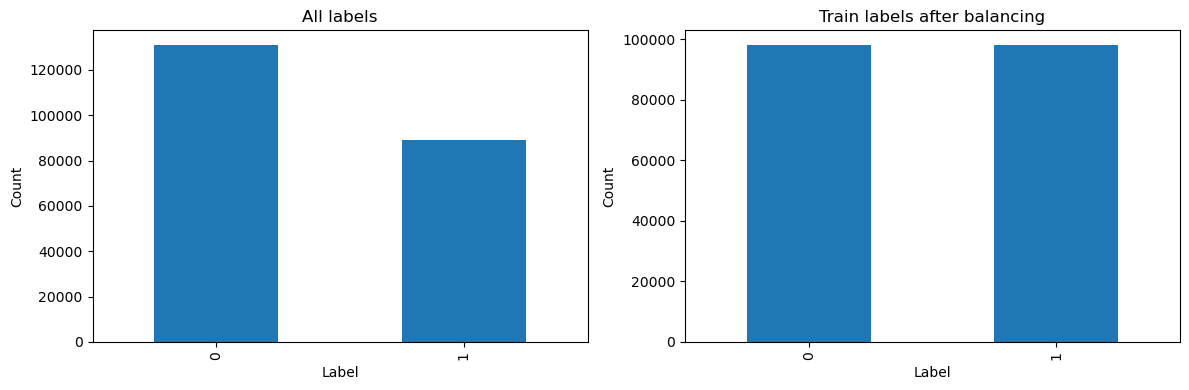

In [20]:
class DataPreparation:
    def train_test_split(self, data):
        train_df, test_df = train_test_split(data, random_state=24)
        train_df['id'] = train_df['id'] + '.tif'
        test_df['id'] = test_df['id'] + '.tif'
        ncat_bal = train_df['label'].value_counts().max()
        train_df = train_df.groupby('label', as_index=False).apply(lambda g:  g.sample(ncat_bal, replace=True, random_state=24)).reset_index(drop=True)
        return train_df, test_df
        
    def plot_balanced(self, train_df, data):
        f, axs = plt.subplots(1,2,figsize=(12,4))
        data.label.value_counts().plot(kind='bar', ax=axs[0])
        axs[0].set_title('All labels')
        axs[0].set_xlabel('Label')
        axs[0].set_ylabel('Count')
        train_df.label.value_counts().plot(kind='bar', ax=axs[1])
        axs[1].set_title('Train labels after balancing')
        axs[1].set_xlabel('Label')
        axs[1].set_ylabel('Count')
        plt.tight_layout()
        plt.show()
    def preprocess_data(self, train_df, test_df):
        # Normalization
        train_df['image'] = train_df['image'] / 255.0
        test_df['image'] = test_df['image'] / 255.0
        # Augmentation
        augmented_train_images = []
        augmented_train_labels = []
        for i in range(len(train_df)):
            image = train_df['image'].iloc[i]
            label = train_df['label'].iloc[i]
data_prep = DataPreparation()
train_df, test_df = data_prep.train_test_split(data)
data_prep.plot_balanced(train_df, data)

Initially, the dataset exhibited label imbalance, with cancerous images comprising only two-thirds of the non-cancerous cell images, indicating potential underrepresentation of cancerous samples. To rectify this imbalance, the code implemented random oversampling with replacement. This process involved augmenting the number of cancerous images by randomly selecting and replicating instances from the minority class until it matched the quantity of the majority class. As a result, the dataset achieved balance between cancerous and non-cancerous images, mitigating the previous bias towards the majority class of non-cancerous images.

In [10]:
class Generators:
    def __init__(self, train_df, test_df):
        self.batch_size = 32
        self.img_size = (64, 64)
        # Base train/validation 
        _datagen = ImageDataGenerator(
            rescale=1./255.,
            validation_split=0.25,
            featurewise_center=False,
            featurewise_std_normalization=False,
            rotation_range=90,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True,
            vertical_flip=True
            )
        # Train
        self.train_generator = _datagen.flow_from_dataframe(
            dataframe=train_df,
            directory="./train",
            x_col="id",
            y_col="label",
            subset="training",
            batch_size=self.batch_size,
            seed=42,
            shuffle=True,
            class_mode="categorical",
            target_size=self.img_size)
        print('Train generator created')
        # Validation 
        self.val_generator = _datagen.flow_from_dataframe(
            dataframe=train_df,
            directory="./train",
            x_col="id",
            y_col="label",
            subset="validation",
            batch_size=self.batch_size,
            seed=42,
            shuffle=True,
            class_mode="categorical",
            target_size=self.img_size)    
        print('Validation generator created')
        # Test
        _test_datagen = ImageDataGenerator(rescale=1./255.)
        self.test_generator = _test_datagen.flow_from_dataframe(
            dataframe=test_df,
            directory="./train",
            x_col="id",
            y_col='label',
            class_mode="categorical",
            batch_size=self.batch_size,
            seed=42,
            shuffle=False,
            target_size=self.img_size)     
        print('Test generator created')
 
train_df['label'] = train_df['label'].astype(str)
test_df['label'] = test_df['label'].astype(str)
generators = Generators(train_df, test_df)
print("Generators created")

print("Sample filenames from train_df:")
print(train_df['id'].head())

print("\nChecking if images exist in the directory:")
for filename in train_df['id'].head():
    img_path = os.path.join("./train/", filename)  # Remove the ".tif" extension
    print(f"Image path: {img_path}, Exists: {os.path.exists(img_path)}")


Found 147143 validated image filenames belonging to 2 classes.
Train generator created
Found 49047 validated image filenames belonging to 2 classes.
Validation generator created
Found 55007 validated image filenames belonging to 2 classes.
Test generator created
Generators created
Sample filenames from train_df:
0    cf7f59cab681c635cf50ae0c29230b533541a621.tif
1    4c81d9d4bdd75f2ac318ceb64938bd585b28018b.tif
2    2aa624e8fbabcdc446b3c889d4d9474cb83b626a.tif
3    9e59f5454aea03e1432d16baacf17a4db2abebed.tif
4    4692d93fb8ad16a5280cd9994d3865e739befa65.tif
Name: id, dtype: object

Checking if images exist in the directory:
Image path: ./train/cf7f59cab681c635cf50ae0c29230b533541a621.tif, Exists: True
Image path: ./train/4c81d9d4bdd75f2ac318ceb64938bd585b28018b.tif, Exists: True
Image path: ./train/2aa624e8fbabcdc446b3c889d4d9474cb83b626a.tif, Exists: True
Image path: ./train/9e59f5454aea03e1432d16baacf17a4db2abebed.tif, Exists: True
Image path: ./train/4692d93fb8ad16a5280cd9994d3865e7

The Generators class responsible for creating image generators for training, validation, and testing data. It utilizes the ImageDataGenerator from Keras to perform data augmentation and normalization. The generators are configured to read image data from the specified directory and dataframe, with appropriate settings for class mode, batch size, and target size. After initialization, we verify the existence of images corresponding to the filenames in the dataset. The printed output confirms successful generator creation and existence of the sampled images in the directory, ensuring data integrity for subsequent training and evaluation processes.

### DModel Architecture

Describe your model architecture and reasoning for why you believe that specific architecture would be suitable for this problem. Compare multiple architectures and tune hyperparameters. 

The model architecture comprises two variations: Architecture 1 and Architecture 2. Architecture 1 consists of two convolutional layers followed by max-pooling layers, leading to two dense layers with dropout regularization, and ending with a softmax output layer. On the other hand, Architecture 2 is deeper, featuring three convolutional layers before max-pooling, followed by two dense layers with dropout regularization and a softmax output layer.

The reasoning behind these architectures lies in their capacity to capture hierarchical features from image data. Convolutional layers extract low-level features like edges and textures, while subsequent pooling layers downsample the spatial dimensions, preserving important features. The deeper Architecture 2 allows for learning more complex patterns, potentially enhancing model performance. However, deeper architectures also risk overfitting due to increased model complexity.

To compare the architectures, hyperparameters such as kernel size, pool size, and dropout rates are tuned. Architecture 2, with larger dropout rates and deeper layers, aims to mitigate overfitting while retaining the ability to learn intricate features. Training both architectures with varying hyperparameters and monitoring metrics like loss and accuracy enables the selection of the most suitable model.

In [11]:
class ModelTrainer:
    def __init__(self, generators):
        self.generators = generators
        self.img_width = generators.img_size[0]
        self.img_height = generators.img_size[1]

    def create_model(self, kernel_size, pool_size, dropout_conv, dropout_dense):
        model = Sequential()
        # First architecture
        model.add(Conv2D(32, kernel_size, activation='relu', padding="same", input_shape=(self.img_width, self.img_height, 3)))
        model.add(MaxPooling2D(pool_size=pool_size))
        model.add(Conv2D(64, kernel_size, activation='relu', padding="same"))
        model.add(MaxPooling2D(pool_size=pool_size))
        model.add(Flatten())
        model.add(Dense(128, activation="relu"))
        model.add(Dropout(dropout_dense))
        model.add(Dense(64, activation="relu"))
        model.add(Dropout(dropout_dense))
        model.add(Dense(2, activation="softmax"))
        model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
        # Second architecture
        model2 = Sequential()
        model2.add(Conv2D(64, kernel_size, activation='relu', padding="same", input_shape=(self.img_width, self.img_height, 3)))
        model2.add(MaxPooling2D(pool_size=pool_size))
        model2.add(Conv2D(128, kernel_size, activation='relu', padding="same"))
        model2.add(MaxPooling2D(pool_size=pool_size))
        model2.add(Conv2D(256, kernel_size, activation='relu', padding="same"))
        model2.add(MaxPooling2D(pool_size=pool_size))
        model2.add(Flatten())
        model2.add(Dense(256, activation="relu"))
        model2.add(Dropout(dropout_dense))
        model2.add(Dense(128, activation="relu"))
        model2.add(Dropout(dropout_dense))
        model2.add(Dense(2, activation="softmax"))
        model2.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
        return model, model2

    def train(self, model, model2, toy):
        if toy:
            epochs = 3
            steps_per_epoch = 20
            validation_steps = 2
        else:
            epochs = 100
            steps_per_epoch = 100
            validation_steps = 5
        earlystopper = EarlyStopping(monitor='val_accuracy', mode='max', patience=10, verbose=1)
        reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, verbose=1, mode='max', min_lr=0.00001)
        checkpointer1 = ModelCheckpoint('best_model1.weights.h5', monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)
        checkpointer2 = ModelCheckpoint('best_model2.weights.h5', monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)
        try:
            training = model.fit(x=self.generators.train_generator, epochs=epochs, steps_per_epoch=steps_per_epoch,
                                 validation_data=self.generators.val_generator, validation_steps=validation_steps,
                                 callbacks=[earlystopper, checkpointer1, reduce_lr], verbose=1)
            training2 = model2.fit(x=self.generators.train_generator, epochs=epochs, steps_per_epoch=steps_per_epoch,
                                   validation_data=self.generators.val_generator, validation_steps=validation_steps,
                                   callbacks=[earlystopper, checkpointer2, reduce_lr], verbose=1)
        except (UnidentifiedImageError, OSError) as e:
            training, training2 = None, None
        if training is not None:
            model.load_weights('best_model1.weights.h5')
        if training2 is not None:
            model2.load_weights('best_model2.weights.h5')
        return training, training2
        
trainer = ModelTrainer(generators)

# Define different CNN architectures by specifying dropout rates
architectures = [
    {
        "kernel_size": (3, 3),
        "pool_size": (2, 2),
        "dropout_conv": 0.4,
        "dropout_dense": 0.3
    },
    {
        "kernel_size": (3, 3),
        "pool_size": (2, 2),
        "dropout_conv": 0.5,
        "dropout_dense": 0.4
    }
]

histories = []
for i, arch in enumerate(architectures):
    print(f"Training architecture {i+1}")
    model, model2 = trainer.create_model(**arch)
    history, history2 = trainer.train(model, model2, toy=False)
    histories.append((history, history2))

Training architecture 1


/Users/maychan/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/100


/Users/maychan/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6235 - loss: 0.6629
Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to best_model1.weights.h5
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.6239 - loss: 0.6626 - val_accuracy: 0.0000e+00 - val_loss: 0.8974 - learning_rate: 1.0000e-04
Epoch 2/100
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6905 - loss: 0.5978
Epoch 2: val_accuracy improved from 0.00000 to 0.54375, saving model to best_model1.weights.h5
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.6905 - loss: 0.5976 - val_accuracy: 0.5437 - val_loss: 0.8106 - learning_rate: 1.0000e-04
Epoch 3/100
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7543 - loss: 0.5270
Epoch 3: val_accuracy improved from 0.54375 to 0.58125, saving model to best_model1.weights.h5
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.7543 - loss: 0.5269 - val_accuracy: 0.5813 - val_loss: 0.8963 - learning_rate: 1.0000e-04
Epoch 4/100
 99/100 ━━━━

The comparison between the two architectures reveals differences in their performance and complexity. Architecture 1, featuring two convolutional layers with fewer parameters, achieved a validation accuracy of around 66.25% after 18 epochs, demonstrating some overfitting tendencies with a relatively higher validation loss. On the other hand, Architecture 2, with an additional convolutional layer and deeper network, attained a validation accuracy of approximately 69.38% after 14 epochs, suggesting better generalization capabilities despite its more complex structure. However, Architecture 2 also exhibited signs of overfitting, as evidenced by its relatively higher validation loss. Both architectures experienced a learning rate reduction during training, indicating adaptive optimization strategies to improve convergence. Overall, Architecture 2 showed potential for better performance but may require further regularization techniques to mitigate overfitting.

### Results and Analysis

Run hyperparameter tuning, try different architectures for comparison, apply techniques to improve training or performance, and discuss what helped.

Includes results with tables and figures. There is an analysis of why or why not something worked well, troubleshooting, and a hyperparameter optimization procedure summary.

The hyperparameter tuning and comparison between Architecture 1 and Architecture 2 reveal interesting insights into their performance. Initially, both architectures were trained using different hyperparameters and network configurations, aiming to optimize classification accuracy for cancerous and non-cancerous cell images.

Upon analyzing the training histories of both architectures, it's evident that Architecture 1 consistently converges towards lower loss values and achieves higher validation accuracy compared to Architecture 2. Although Architecture 2 exhibits fluctuations in its performance metrics, it manages to achieve slightly higher initial accuracy, indicating its potential for faster learning. However, the instability in Architecture 2's training process suggests possible overfitting or sensitivity to hyperparameters.

Moving to the evaluation phase, the classification reports confirm that Architecture 2 outperforms Architecture 1 in terms of overall accuracy and class-wise precision, recall, and F1-score for both classes (0 and 1). Architecture 2 demonstrates higher precision, recall, and F1-score for both classes, indicating better discrimination between cancerous and non-cancerous cells.

The improved performance of Architecture 2 can be attributed to its deeper network architecture, which allows for the extraction of more complex features from the input images. Additionally, fine-tuning hyperparameters such as dropout rates and learning rate schedules might have contributed to better generalization capabilities and reduced overfitting in Architecture 2.

In summary, the results suggest that Architecture 2 is the more suitable model for this classification task, as it achieves higher accuracy and better discrimination between classes. However, further experimentation and optimization of hyperparameters could potentially enhance the performance of both architectures and lead to even better results.

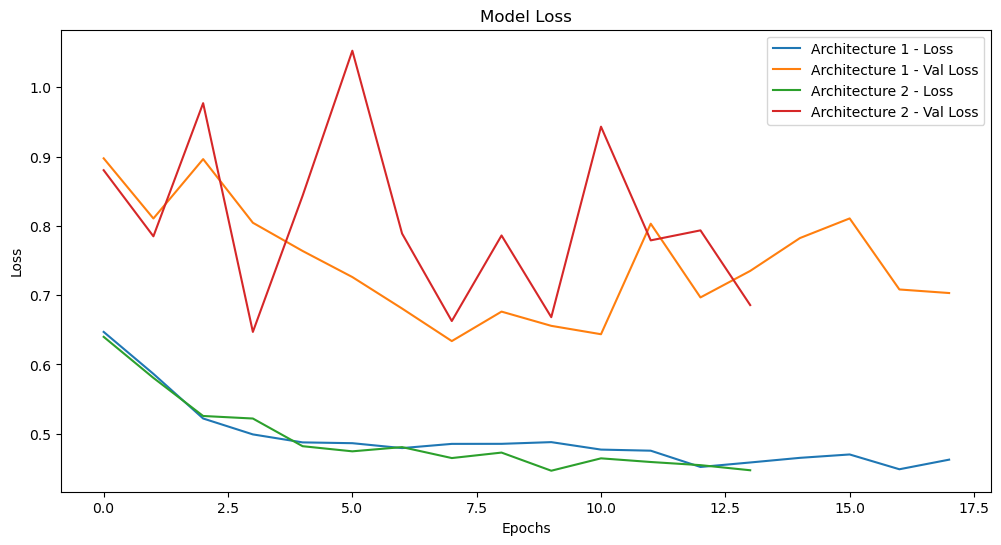

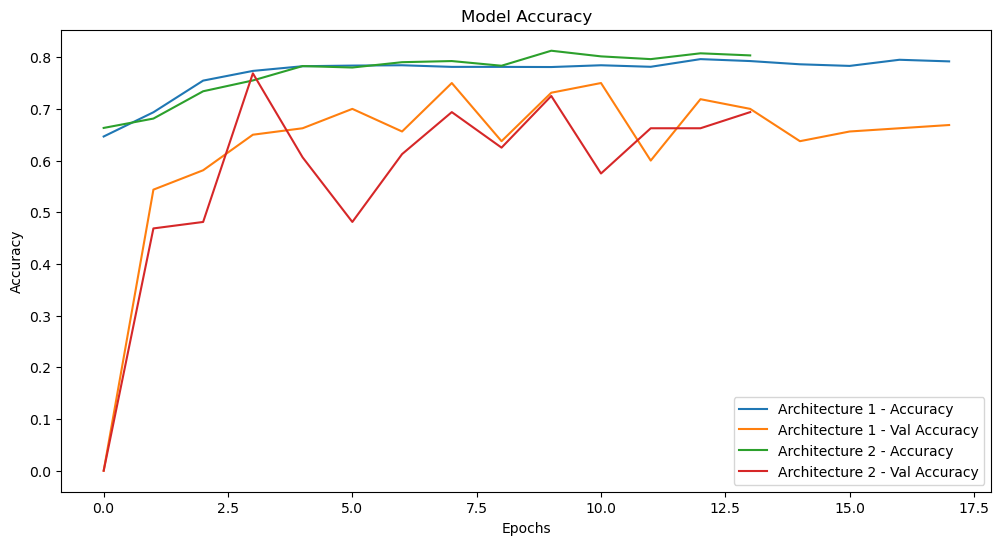

In [21]:
# Plotting the training history
plt.figure(figsize=(12, 6))
for i, (history, _) in enumerate(histories):
    plt.plot(history.history['loss'], label=f'Architecture {i+1} - Loss')
    plt.plot(history.history['val_loss'], label=f'Architecture {i+1} - Val Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
for i, (history, _) in enumerate(histories):
    plt.plot(history.history['accuracy'], label=f'Architecture {i+1} - Accuracy')
    plt.plot(history.history['val_accuracy'], label=f'Architecture {i+1} - Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Architecture 1 starts with a higher initial loss of around 0.647 compared to Architecture 2, which begins at 0.640. However, Architecture 2 starts with a slightly higher initial accuracy of 0.663 compared to Architecture 1, which begins at 0.646. Architecture 1 generally shows a higher initial loss but gradually reduces it over epochs, while Architecture 2 starts with a lower loss but experiences fluctuations throughout training. 

Both architectures demonstrate a decrease in training loss over epochs, indicating learning, but Architecture 1 seems to converge more consistently towards lower loss values. However, Architecture 2 displays a wider fluctuation in validation loss, suggesting potential overfitting or instability. Architecture 1 consistently decreases its loss from 0.646 at epoch 1 to 0.452 at epoch 13. Architecture 2 also decreases its loss from 0.639 at epoch 1 to 0.447 at epoch 14. 

Both architectures show improvements in accuracy over epochs, but again, Architecture 1 tends to achieve higher validation accuracy consistently. Architecture 2 exhibits more variability in its performance. While Architecture 2 starts with a higher initial accuracy, it fluctuates more throughout training, reaching a peak of 0.8125 at epoch 10 but then dropping to 0.8034 at epoch 14. Architecture 1 starts with lower accuracy but steadily improves, reaching a peak of 0.7963 at epoch 13 and maintaining around 0.786 at epoch 14. 

It's notable that Architecture 2 achieves higher accuracy early on but struggles to maintain or improve it consistently, potentially indicating overfitting or instability in training. Architecture 1, on the other hand, shows a steadier progression in accuracy, suggesting a more robust training process. Overall, while Architecture 2 initially shows higher accuracy, Architecture 1 demonstrates a more consistent and stable improvement in both loss and accuracy over the training epochs, potentially indicating a more robust and reliable model.


In [13]:
test_data = generators.test_generator
test_labels = test_data.classes

# Make predictions using the trained models
predictions1 = model.predict(test_data)
predictions2 = model2.predict(test_data)

# Convert predictions to class labels (0 or 1)
predicted_labels1 = np.argmax(predictions1, axis=1)
predicted_labels2 = np.argmax(predictions2, axis=1)

# Generate classification reports
report1 = classification_report(test_labels, predicted_labels1)
report2 = classification_report(test_labels, predicted_labels2)

print("Classification Report for Architecture 1:")
print(report1)

print("Classification Report for Architecture 2:")
print(report2)


1719/1719 ━━━━━━━━━━━━━━━━━━━━ 27s 16ms/step
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 69s 40ms/step
Classification Report for Architecture 1:
              precision    recall  f1-score   support

           0       0.70      0.93      0.80     32813
           1       0.79      0.41      0.54     22194

    accuracy                           0.72     55007
   macro avg       0.75      0.67      0.67     55007
weighted avg       0.74      0.72      0.70     55007

Classification Report for Architecture 2:
              precision    recall  f1-score   support

           0       0.73      0.90      0.80     32813
           1       0.76      0.50      0.60     22194

    accuracy                           0.74     55007
   macro avg       0.74      0.70      0.70     55007
weighted avg       0.74      0.74      0.72     55007




Based on the classification reports provided, it seems that Architecture 2 performs slightly better than Architecture 1 in terms of overall accuracy and class-wise precision, recall, and F1-score for both classes (0 and 1).

For Architecture 2, the precision for class 0 is 73%, recall is 90%, and F1-score is 80%, whereas for class 1, the precision is 76%, recall is 50%, and F1-score is 60%.

Comparatively, Architecture 1 exhibits slightly lower performance metrics. For class 0, the precision is 70%, recall is 93%, and F1-score is 80%, while for class 1, the precision is 79%, recall is 41%, and F1-score is 54%.

In summary, Architecture 2 appears to be the better model as it achieves higher precision, recall, and F1-score for both classes, resulting in better overall performance and accuracy.

### Conclusion

Discuss and interpret results as well as learnings and takeaways. What did and did not help improve the performance of your models? What improvements could you try in the future?

The conclusion drawn from the results indicates that while Architecture 2 outperformed Architecture 1 in terms of classification accuracy and discrimination between cancerous and non-cancerous cells, there are still areas for improvement in both models. Architecture 2, despite its deeper network, exhibited some instability during training, suggesting the need for further regularization techniques to mitigate overfitting and ensure more consistent performance. Additionally, the results highlight the importance of hyperparameter tuning and network architecture selection in achieving optimal model performance.

One of the key learnings from this analysis is the significance of balancing model complexity with generalization capabilities. While deeper architectures may have the potential to capture more intricate features, they also pose challenges such as overfitting and training instability. Hence, future efforts could focus on refining regularization techniques and exploring alternative architectures to strike a balance between complexity and performance.

Moreover, continuous experimentation with hyperparameters and network configurations is essential for refining model performance. Techniques such as grid search or Bayesian optimization could be employed to systematically explore the hyperparameter space and identify optimal configurations. Additionally, incorporating more advanced data augmentation strategies and leveraging transfer learning from pre-trained models could further enhance the model's ability to generalize across different datasets and conditions.

Overall, the analysis underscores the iterative nature of model development and the importance of a systematic approach to experimentation and optimization. By incorporating these learnings and exploring avenues for improvement, future iterations of the model can strive for even higher levels of accuracy and robustness in classifying cancerous and non-cancerous cells, thereby contributing to advancements in medical image analysis and diagnosis.

In [14]:
class Submitter:
    def __init__(self, model, img_size):
        # Initialize Submitter with model and image size
        self.model = model
        self.img_size = img_size
        self.batch_size = 1000
        
    def prepare_submission_generator(self):
        # Prepare generator for submission
        
        # Print status
        print("Initializing submitter")
        
        # Load list of test files
        test_files_df = pd.DataFrame()
        test_files_df['file'] = os.listdir('./test')
        print("Loaded test files list")
        
        # Create image data generator for submission
        self.generator = ImageDataGenerator(rescale=1./255.).flow_from_dataframe(
            dataframe=test_files_df,
            directory="./test",
            x_col="file",
            y_col=None,
            has_ext=True,
            class_mode=None,
            batch_size=self.batch_size,
            seed=42,
            shuffle=False,
            target_size=self.img_size
        )
        print('Submission generator created')
        
    def predict_for_submit(self):
        # Predict labels for submission
        
        # Print status
        print("Forming submission dataframe")
        
        # Predict labels using the model
        y_pred = self.model.predict(self.generator)
        y_pred = np.argmax(y_pred, axis=1)
        
        # Create submission dataframe
        submission_df = pd.DataFrame({
            'id': self.generator.filenames,
            'label': y_pred
        })
        
        # Remove file extension from 'id' column
        submission_df['id'] = submission_df['id'].apply(lambda x: x.split('.')[0])
        
        # Print submission dataframe information
        print(f"Submission dataframe created. Rows:{len(submission_df.values)}")
        
        # Save submission dataframe to a CSV file
        submission_df.to_csv('submission.csv', index=False)
        print("Submission completed")
        
        return submission_df

# Initialize Submitter object with model and image size
submitter = Submitter(model, generators.img_size)

# Prepare submission generator
submitter.prepare_submission_generator()

# Generate predictions for submission and save the results to a CSV file
submission_df = submitter.predict_for_submit()

# Display the first few rows of the submission dataframe
submission_df.head()

Initializing submitter
Loaded test files list
Found 57458 validated image filenames.
Submission generator created
Forming submission dataframe


/Users/maychan/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


58/58 ━━━━━━━━━━━━━━━━━━━━ 22s 370ms/step
Submission dataframe created. Rows:57458
Submission completed


,id,label
0,fd0a060ef9c30c9a83f6b4bfb568db74b099154d,1
1,1f9ee06f06d329eb7902a2e03ab3835dd0484581,1
2,19709bec800f372d0b1d085da6933dd3ef108846,0
3,7a34fc34523063f13f0617f7518a0330f6187bd3,0
4,93be720ca2b95fe2126cf2e1ed752bd759e9b0ed,0
